<a href="https://colab.research.google.com/github/Giuseppe-Mauro/Neuromorphic_KAN_PB/blob/main/Training_BSpline_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== CONFIGURAZIONE INIZIALE ===
Punti di controllo: [(0, 0.8), (4, 5), (8, -1.2), (12, 2.8)]
Learning rate: 0.003
PTP (distanza tra punti): 4
=== VERIFICA CONSISTENZA ===
P0: Y1(0) = 0.800000, expected = 0.800000, diff = 0.000000
P1: Y1(4) = 5.000000, Y2(4) = 5.000000, expected = 5.000000
     diff Y1 = 0.000000, diff Y2 = 0.000000
P2: Y2(8) = -1.200000, Y3(8) = -1.200000, expected = -1.200000
     diff Y2 = 0.000000, diff Y3 = 0.000000
P3: Y3(12) = 2.800000, expected = 2.800000, diff = 0.000000


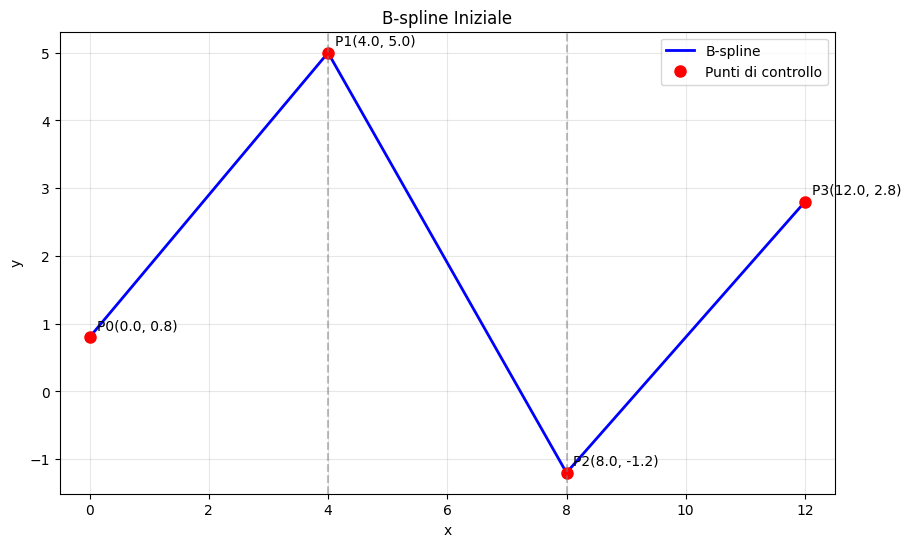


=== ADDESTRAMENTO ===
Sample 1: x=1.00, target=10.00, error=-8.1500, updated_points=[0, 1]
Sample 2: x=2.00, target=-9.00, error=11.9000, updated_points=[0, 1]
Sample 3: x=3.00, target=-27.00, error=30.9265, updated_points=[0, 1]
Sample 4: x=5.00, target=12.00, error=-8.7940, updated_points=[1, 2]
Sample 5: x=6.00, target=3.00, error=-1.2626, updated_points=[1, 2]
Sample 6: x=7.00, target=-12.00, error=12.3460, updated_points=[1, 2]
Sample 7: x=9.00, target=1.00, error=-1.2785, updated_points=[2, 3]
Sample 8: x=10.00, target=-6.50, error=7.2477, updated_points=[2, 3]
Sample 9: x=11.00, target=-17.00, error=18.6824, updated_points=[2, 3]
Epoch 1: Average MSE = 199.892134


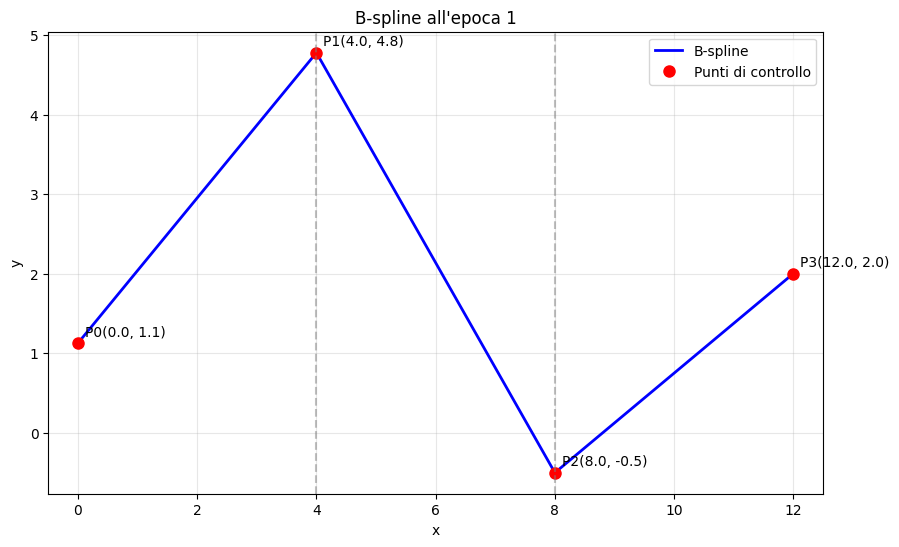

Epoch 2: Average MSE = 198.383671


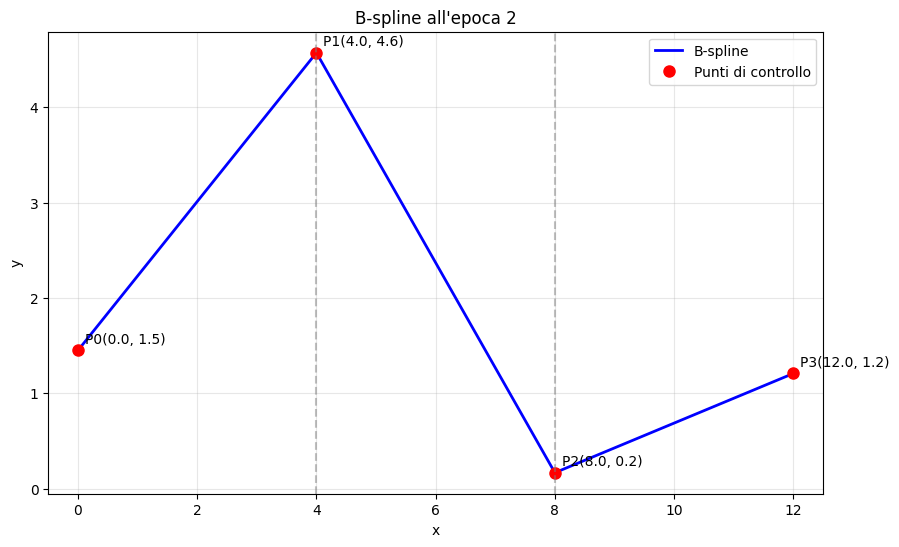

Epoch 3: Average MSE = 197.040770


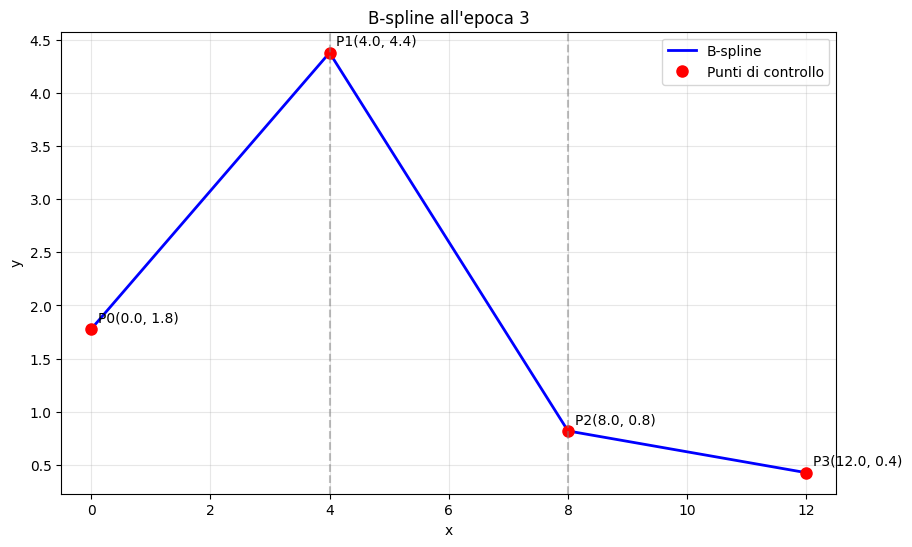

Epoch 4: Average MSE = 195.855677


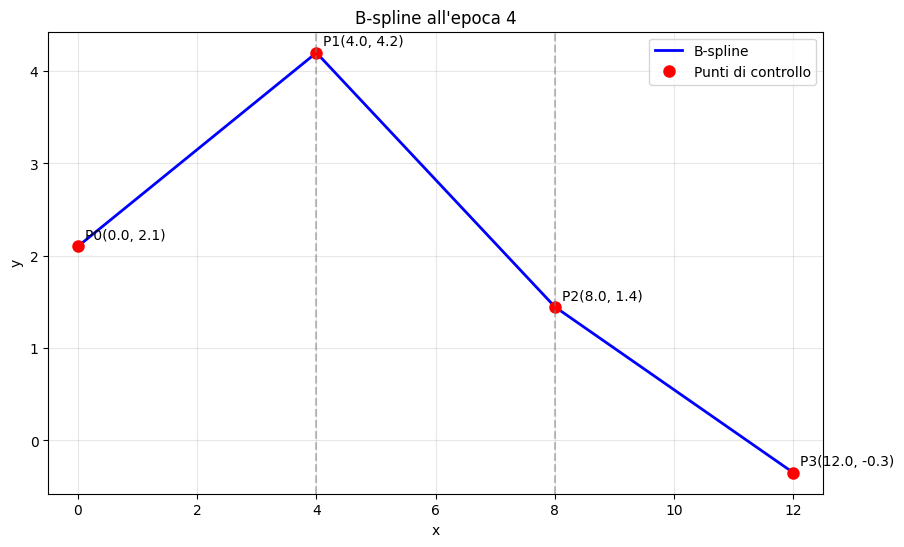

Epoch 5: Average MSE = 194.820672


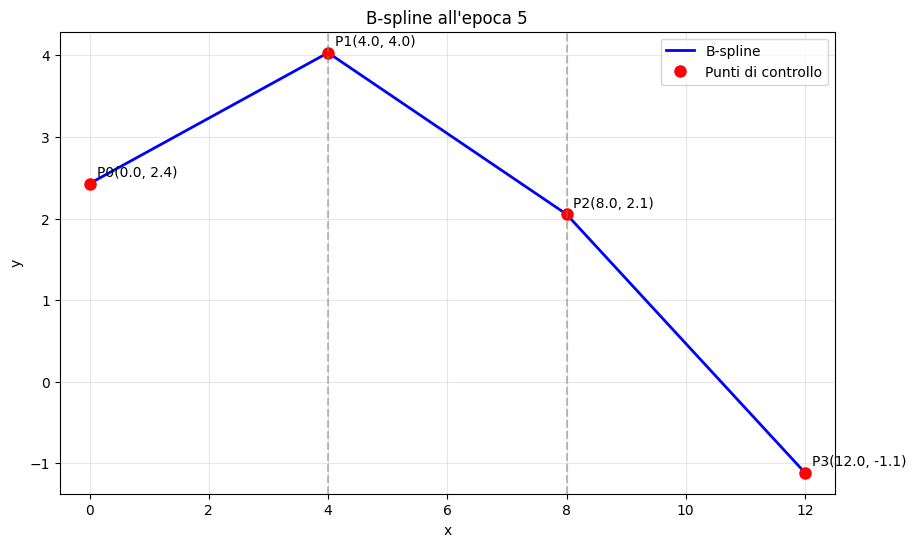

Epoch 6: Average MSE = 193.928093


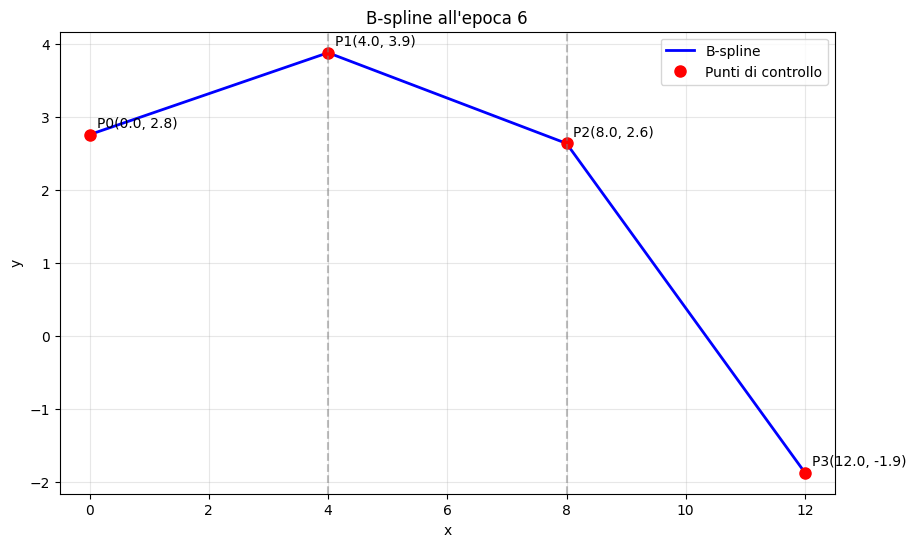

Epoch 7: Average MSE = 193.170353


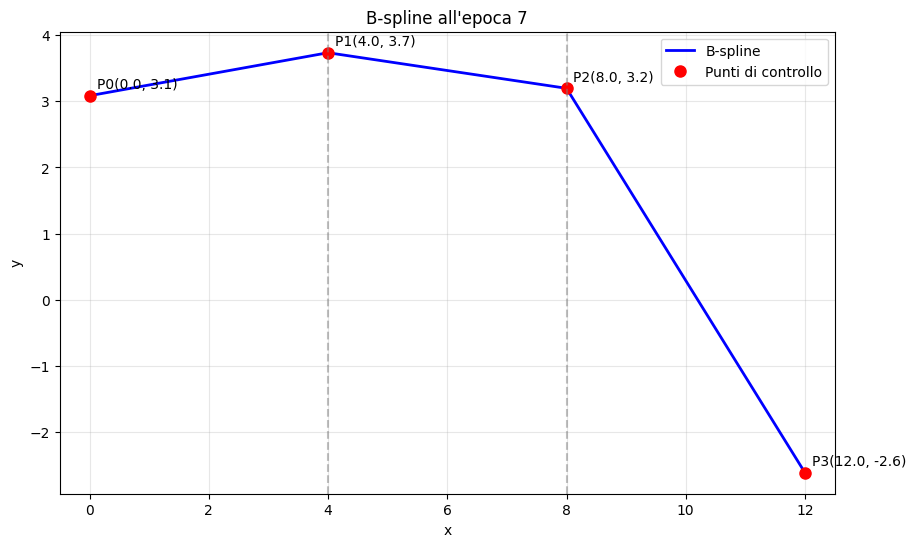

Epoch 8: Average MSE = 192.539955


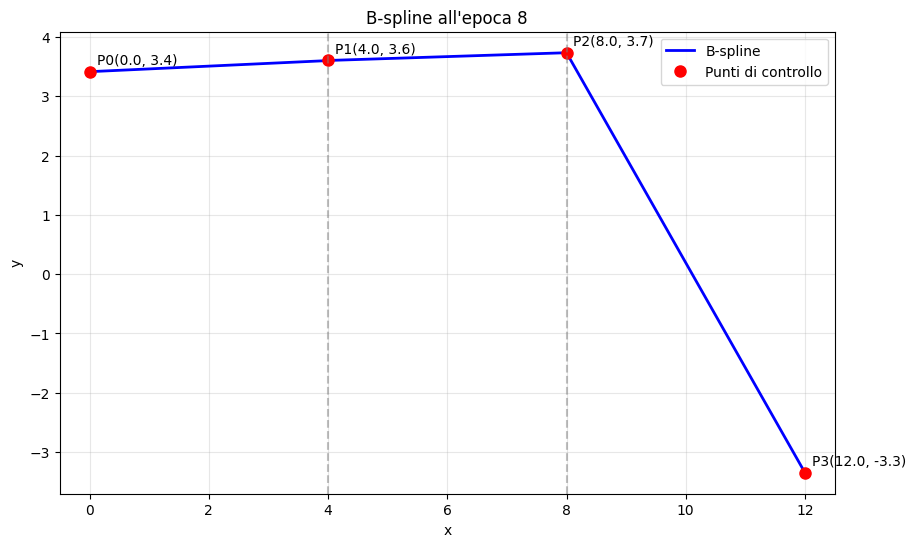

Epoch 9: Average MSE = 192.029515


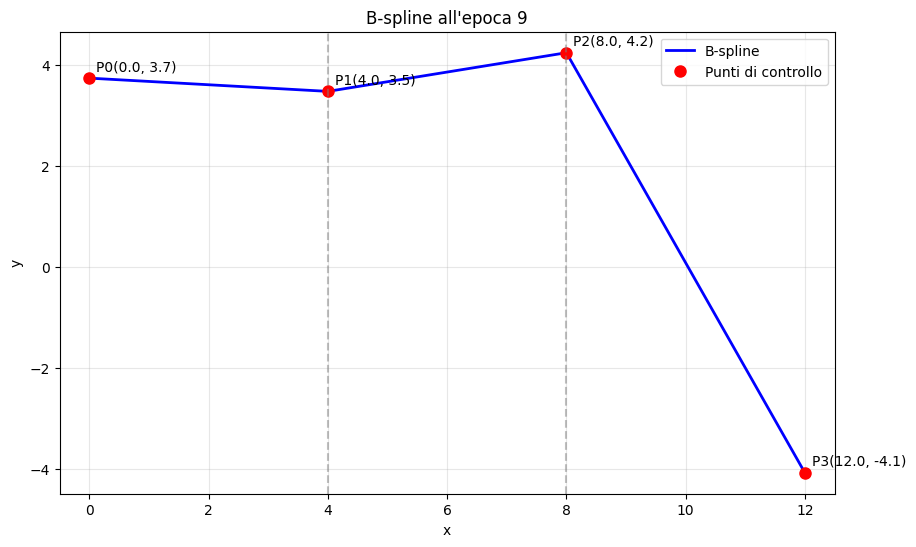

Epoch 10: Average MSE = 191.631776


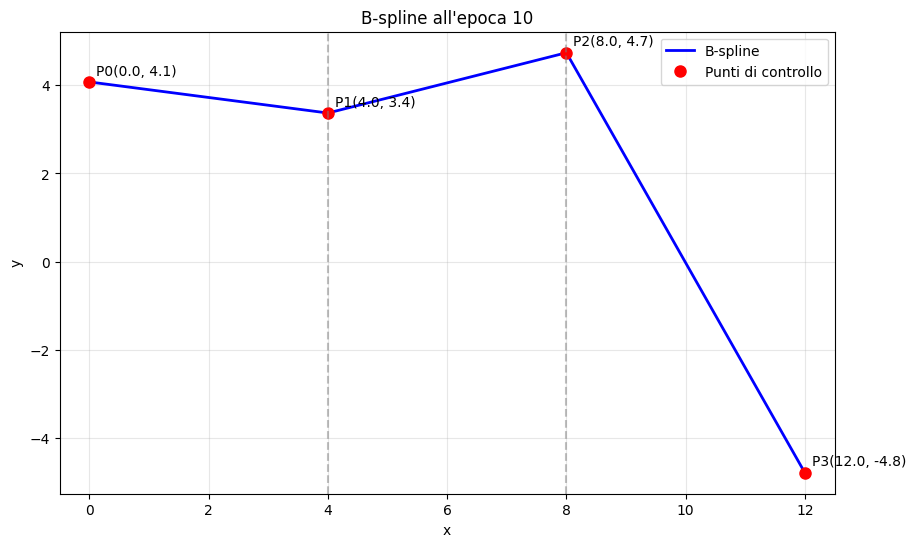


=== CONFIGURAZIONE FINALE ===
Punti di controllo finali: [(np.int64(0), np.float64(4.075229943817445)), (np.int64(4), np.float64(3.3707315394645256)), (np.int64(8), np.float64(4.7378033202610546)), (np.int64(12), np.float64(-4.783764803543024))]
=== VERIFICA CONSISTENZA ===
P0: Y1(0) = 4.075230, expected = 4.075230, diff = 0.000000
P1: Y1(4) = 3.370732, Y2(4) = 3.370732, expected = 3.370732
     diff Y1 = 0.000000, diff Y2 = 0.000000
P2: Y2(8) = 4.737803, Y3(8) = 4.737803, expected = 4.737803
     diff Y2 = 0.000000, diff Y3 = 0.000000
P3: Y3(12) = -4.783765, expected = -4.783765, diff = 0.000000


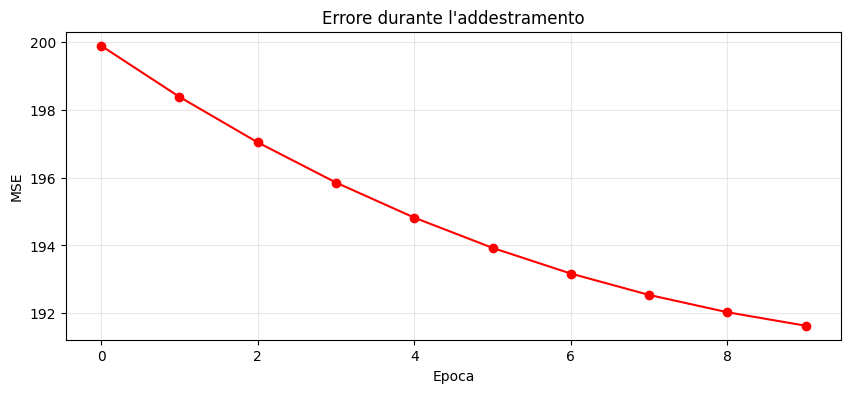


=== TEST SU NUOVI DATI ===
Input: 1.5 -> Output: 3.811 (Segmento: 0)
Input: 4.5 -> Output: 3.542 (Segmento: 1)
Input: 9.5 -> Output: 1.167 (Segmento: 2)


In [2]:
#///////////////////////////////////////////////////////////////////////////////
#///////////////////// ADDESTRAMENTO B-SPLINE //////////////////////////////////
#///////////////////////////////////////////////////////////////////////////////

import numpy as np
import matplotlib.pyplot as plt

class BSplineKAN:
    def __init__(self, points_x, points_y, ptp, learning_rate):
        """
        Inizializza la B-spline lineare

        Args:
            points_x: array delle ascisse dei 4 punti (equidistanti)
            points_y: array delle ordinate dei 4 punti
            ptp: distanza tra le ascisse dei punti (costante)
            learning_rate: tasso di apprendimento η
        """
        self.points_x = np.array(points_x)
        self.points_y = np.array(points_y.copy())
        self.ptp = ptp
        self.learning_rate = learning_rate

        # Verifica che ci siano esattamente 4 punti
        if len(self.points_x) != 4 or len(self.points_y) != 4:
            raise ValueError("Devono essere forniti esattamente 4 punti")

        # Calcola i coefficienti iniziali delle tre rette tramite formula geometrica (retta per due punti)
        self.update_line_coefficients()

    def update_line_coefficients(self):
        """Calcola i coefficienti delle tre rette Y1, Y2, Y3 usando la formula geometrica iniziale"""
        # Y1: retta tra punto 0 e punto 1
        self.A1 = (self.points_y[1] - self.points_y[0]) / (self.points_x[1] - self.points_x[0])
        self.B1 = self.points_y[0] - self.A1 * self.points_x[0]

        # Y2: retta tra punto 1 e punto 2
        self.A2 = (self.points_y[2] - self.points_y[1]) / (self.points_x[2] - self.points_x[1])
        self.B2 = self.points_y[1] - self.A2 * self.points_x[1]

        # Y3: retta tra punto 2 e punto 3
        self.A3 = (self.points_y[3] - self.points_y[2]) / (self.points_x[3] - self.points_x[2])
        self.B3 = self.points_y[2] - self.A3 * self.points_x[2]

    def update_incremental_coefficients(self, point_index, delta_W):
        """
        Aggiorna i coefficienti delle rette in modo incrementale utilizzando un set di equazioni
        che consentono di ricalcolare coefficiente angolare ed intercetta delle due rette interessate dal k-esimo punto
        addestrabile in modo da ottenere due nuove rette che continuano a passare per i punti k-1 e k+1 e che a fine addestramento
        intercetteranno la nuova ordinata ottenuta dall'aggiornamento del peso.

        questo set di equazioni permette l'aggiornamento delle rette conoscendo solo le coordinate del punto interessato, non occorre
        conoscere 3 punti e ricalcolarsi tutti e 3 i segmenti da capo tramite forula geometrica. E' garantita inoltre una maggiore
        precisione nell'approssimazione numerica delle interpolazioni.

        Args:
            point_index: indice del punto che è stato modificato (0, 1, 2, o 3)
            delta_W: variazione ΔW = -η * error * x
        """

        if point_index == 0:
            # Punto P0: aggiorna solo il segmento Y1 (A1, B1)
            # Il punto P0 è l'estremo sinistro del segmento Y1
            self.A1 -= delta_W / self.ptp
            self.B1 += (self.points_x[1] / self.ptp) * delta_W

        elif point_index == 1:
            # Punto P1: aggiorna i segmenti Y1 e Y2 (A1, B1, A2, B2)
            # P1 è il punto di connessione tra Y1 e Y2
            # Y1 è la retta "prima" (A, B), Y2 è la retta "dopo" (C, D)

            # Aggiornamento per Y1 (A=A1, B=B1) - retta prima del punto
            self.A1 += delta_W / self.ptp
            self.B1 -= (self.points_x[0] / self.ptp) * delta_W  # x_pk-1 = points_x[0]

            # Aggiornamento per Y2 (C=A2, D=B2) - retta dopo il punto
            self.A2 -= delta_W / self.ptp
            self.B2 += (self.points_x[2] / self.ptp) * delta_W  # x_pk+1 = points_x[2]

        elif point_index == 2:
            # Punto P2: aggiorna i segmenti Y2 e Y3 (A2, B2, A3, B3)
            # P2 è il punto di connessione tra Y2 e Y3
            # Y2 è la retta "prima" (A, B), Y3 è la retta "dopo" (C, D)

            # Aggiornamento per Y2 (A=A2, B=B2) - retta prima del punto
            self.A2 += delta_W / self.ptp
            self.B2 -= (self.points_x[1] / self.ptp) * delta_W  # x_pk-1 = points_x[1]

            # Aggiornamento per Y3 (C=A3, D=B3) - retta dopo il punto
            self.A3 -= delta_W / self.ptp
            self.B3 += (self.points_x[3] / self.ptp) * delta_W  # x_pk+1 = points_x[3]

        elif point_index == 3:
            # Punto P3: aggiorna solo il segmento Y3 (A3, B3)
            # Il punto P3 è l'estremo destro del segmento Y3
            self.A3 += delta_W / self.ptp
            self.B3 -= (self.points_x[2] / self.ptp) * delta_W  # x_pk-1 = points_x[2]

    def forward(self, x):
        """
        Calcola l'output della B-spline per un valore x, dopo aver riconosciuto a quale segmento fa riferimento l'ingresso x.
        schematizza il complesso di comparatori a soglia utilizzati come hardware.

        Args:
            x: valore di input

        Returns:
            y: valore di output
            segment: indice del segmento utilizzato (0, 1, o 2)
        """
        if x < self.points_x[0] or x > self.points_x[3]:
            raise ValueError(f"Input {x} fuori dal range [{self.points_x[0]}, {self.points_x[3]}]")

        # Determina quale segmento utilizzare
        if x <= self.points_x[1]:
            # Segmento Y1
            y = self.A1 * x + self.B1
            segment = 0
        elif x <= self.points_x[2]:
            # Segmento Y2
            y = self.A2 * x + self.B2
            segment = 1
        else:
            # Segmento Y3
            y = self.A3 * x + self.B3
            segment = 2

        return y, segment

    def update_weights(self, x, target):
        """
        Aggiorna i pesi basandosi sull'errore utilizzando l'aggiornamento incrementale

        Args:
            x: valore di input
            target: valore target desiderato

        Returns:
            error: errore calcolato
            updated_points: indici dei punti aggiornati
        """
        # Calcola l'output corrente
        y_pred, segment = self.forward(x)

        # Calcola l'errore
        error = y_pred - target

        '''
        La tecnica utilizzata di update ∆W dei pesi è la Single-Connection Sparse Direct Feedback Alignment (SSDFA)
        che prevede il trasporto all'indietro dell'errore calcolato nel layer di output a tutti i neuroni precedenti
        senza impiego di una chain rule (e dunque di operazioni differenziali sulle funzioni di attivazione).
        in questa simulazione di tiene conto della sinapsi di un solo neurone, per esempio un neurone appartenente al layer finale.

        '''

        # Calcola ∆W
        delta_W = -self.learning_rate * error * x

        # Determina quali punti aggiornare in base al segmento
        if segment == 0:
            # Segmento Y1: aggiorna punti 0 e 1
            pk_indices = [0, 1]
        elif segment == 1:
            # Segmento Y2: aggiorna punti 1 e 2
            pk_indices = [1, 2]
        else:
            # Segmento Y3: aggiorna punti 2 e 3
            pk_indices = [2, 3]

        # Aggiorna i punti utilizzando l'aggiornamento incrementale
        for pk_idx in pk_indices:
            # Calcola ΔW per questo punto, la logica scelta è decrementare l'estremo sinistro e incrementare l'estremo destro (da aggiornare).
            if pk_idx == pk_indices[0]:
                # Primo punto del segmento
                delta_W_point = -delta_W
            else:
                # Secondo punto del segmento
                delta_W_point = delta_W

            # Aggiorna l'ordinata del punto
            # La variazione dell'ordinata è ΔW quando il punto è l'estremo destro del segmento
            # o -ΔW quando è l'estremo sinistro
            self.points_y[pk_idx] += delta_W_point

            # Aggiorna i coefficienti delle rette in modo incrementale
            self.update_incremental_coefficients(pk_idx, delta_W_point)

        return error, pk_indices

    def train(self, x_inputs, targets, epochs, verbose=True):
        """
        Addestra la B-spline su un set di dati

        Args:
            x_inputs: array di valori di input
            targets: array di valori target
            epochs: numero di epoche di addestramento
            verbose: se stampare informazioni durante l'addestramento
        """
        x_inputs = np.array(x_inputs)
        targets = np.array(targets)

        if len(x_inputs) != len(targets):
            raise ValueError("x_inputs e targets devono avere la stessa lunghezza")

        total_errors = []

        for epoch in range(epochs):
            epoch_errors = []

            for i, (x, target) in enumerate(zip(x_inputs, targets)):
                error, updated_points = self.update_weights(x, target)
                epoch_errors.append(error**2)  # MSE

                if verbose and epoch == 0:
                    print(f"Sample {i+1}: x={x:.2f}, target={target:.2f}, "
                          f"error={error:.4f}, updated_points={updated_points}")

            avg_error = np.mean(epoch_errors)
            total_errors.append(avg_error)

            if verbose:
                print(f"Epoch {epoch+1}: Average MSE = {avg_error:.6f}")
            bspline.plot(f"B-spline all'epoca {epoch + 1}")

        return total_errors

    def plot(self, title="B-spline Lineare", x_range=None, show_points=True):
        """
        Visualizza la B-spline corrente

        Args:
            title: titolo del grafico
            x_range: range di x per la visualizzazione
            show_points: se mostrare i punti di controllo
        """
        if x_range is None:
            x_range = (self.points_x[0] - 0.5, self.points_x[3] + 0.5)

        # Crea i punti per il plot
        x_plot = np.linspace(self.points_x[0], self.points_x[3], 1000)
        y_plot = []

        for x in x_plot:
            y, _ = self.forward(x)
            y_plot.append(y)

        # Plot della funzione
        plt.figure(figsize=(10, 6))
        plt.plot(x_plot, y_plot, 'b-', linewidth=2, label='B-spline')

        # Plot dei punti di controllo
        if show_points:
            plt.plot(self.points_x, self.points_y, 'ro', markersize=8, label='Punti di controllo')

            # Annotazioni dei punti
            for i, (x, y) in enumerate(zip(self.points_x, self.points_y)):
                plt.annotate(f'P{i}({x:.1f}, {y:.1f})',
                           (x, y), xytext=(5, 5), textcoords='offset points')

        # Linee verticali per i punti di divisione
        for x in self.points_x[1:-1]:
            plt.axvline(x, color='gray', linestyle='--', alpha=0.5)

        plt.grid(True, alpha=0.3)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(title)
        plt.legend()
        plt.xlim(x_range)
        plt.show()

    def verify_consistency(self):
        """
        Verifica la consistenza tra i coefficienti delle rette e i punti di controllo
        """
        print("=== VERIFICA CONSISTENZA ===")

        # Verifica che i coefficienti delle rette siano consistenti con i punti
        for i in range(4):
            x = self.points_x[i]
            y_expected = self.points_y[i]

            if i == 0:
                y_calc = self.A1 * x + self.B1
                print(f"P{i}: Y1({x}) = {y_calc:.6f}, expected = {y_expected:.6f}, diff = {abs(y_calc - y_expected):.6f}")
            elif i == 1:
                y_calc1 = self.A1 * x + self.B1
                y_calc2 = self.A2 * x + self.B2
                print(f"P{i}: Y1({x}) = {y_calc1:.6f}, Y2({x}) = {y_calc2:.6f}, expected = {y_expected:.6f}")
                print(f"     diff Y1 = {abs(y_calc1 - y_expected):.6f}, diff Y2 = {abs(y_calc2 - y_expected):.6f}")
            elif i == 2:
                y_calc2 = self.A2 * x + self.B2
                y_calc3 = self.A3 * x + self.B3
                print(f"P{i}: Y2({x}) = {y_calc2:.6f}, Y3({x}) = {y_calc3:.6f}, expected = {y_expected:.6f}")
                print(f"     diff Y2 = {abs(y_calc2 - y_expected):.6f}, diff Y3 = {abs(y_calc3 - y_expected):.6f}")
            elif i == 3:
                y_calc = self.A3 * x + self.B3
                print(f"P{i}: Y3({x}) = {y_calc:.6f}, expected = {y_expected:.6f}, diff = {abs(y_calc - y_expected):.6f}")


# Esempio di utilizzo
if __name__ == "__main__":
    # Configurazione iniziale (basata sui punti nel grafico)
    points_x = [0, 4, 8, 12]  # Ascisse dei 4 punti
    points_y = [0.8, 5, -1.2, 2.8]  # Ordinate iniziali dei 4 punti
    ptp = 4  # Distanza tra punti
    learning_rate = 0.003

    # Crea la B-spline
    bspline = BSplineKAN(points_x, points_y, ptp, learning_rate)

    # Visualizza la configurazione iniziale
    print("=== CONFIGURAZIONE INIZIALE ===")
    print(f"Punti di controllo: {list(zip(points_x, points_y))}")
    print(f"Learning rate: {learning_rate}")
    print(f"PTP (distanza tra punti): {ptp}")

    # Verifica consistenza iniziale
    bspline.verify_consistency()

    bspline.plot("B-spline Iniziale")

    # Dati di addestramento
    x_inputs = [1, 2, 3, 5, 6, 7, 9, 10, 11]  # Input di esempio
    targets = [10, -9, -27, 12, 3, -12, 1, -6.5, -17]   # Target corrispondenti

    print("\n=== ADDESTRAMENTO ===")
    errors = bspline.train(x_inputs, targets, epochs=10, verbose=True)

    # Visualizza la configurazione finale
    print("\n=== CONFIGURAZIONE FINALE ===")
    print(f"Punti di controllo finali: {list(zip(bspline.points_x, bspline.points_y))}")

    # Verifica consistenza finale
    bspline.verify_consistency()

    # Plot dell'errore durante l'addestramento
    plt.figure(figsize=(10, 4))
    plt.plot(errors, 'r-', marker='o')
    plt.xlabel('Epoca')
    plt.ylabel('MSE')
    plt.title('Errore durante l\'addestramento')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Test su nuovi dati
    print("\n=== TEST SU NUOVI DATI ===")
    test_x = [1.5, 4.5, 9.5]
    for x in test_x:
        y, segment = bspline.forward(x)
        print(f"Input: {x:.1f} -> Output: {y:.3f} (Segmento: {segment})")